<a id='toc'></a>
# Performance on Unseen Test Set

1. [Setting up the Environment](#envir)
1. [Loading Training and Test Sets](#load)
1. [Testing AdaBoost](#ada)
1. [Summary of Test Set Results](#summary)

<a id='envir'></a>
# 1. Setting up the Environment

[Return](#toc)

In [6]:
import numpy as np
import pandas as pd
from numpy import nan as NaN
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

<a id='load'></a>
# 2. Loading Training and Test Sets

[Return](#toc)

In [2]:
# Reading in the data with the new ratio attributes after correlation 
# analysis and train/test creation
path = 'C:/Users/X/Documents/A_Documents/Cap_Data/CSV'
train_set = pd.read_csv(path + '/train_test_sets/train_set_std_extras.csv')
train_labels = pd.read_csv(path + '/train_test_sets/train_labels_extras.csv')
test_set = pd.read_csv(path + '/train_test_sets/test_set_std_extras.csv')
test_labels = pd.read_csv(path + '/train_test_sets/test_labels_extras.csv')

In [3]:
# A function to test the model on the test set. The model can be trained with different sampling methods

def classify_test_set(clr, train_x, train_y, test_x, test_y, sample_method):
    
    # Create the random samplers
    rus = RandomUnderSampler(random_state=777)
    smote = SMOTE(ratio='minority', random_state=777, n_jobs=-1)

    fig = plt.figure(figsize=(8,6))
        
    # Depending on choice of sampling method - execute sampling
    if sample_method == 'under':
        sampled_x, sampled_y = rus.fit_sample(train_x, train_y)
    elif sample_method == 'over':
        sampled_x, sampled_y = smote.fit_sample(train_x, train_y)
    elif sample_method == 'none':
        sampled_x, sampled_y = train_x, train_y            
    else:
        print('Incorrect Sample Input')
        return
    
    # Train the classifier on the sampled data
    clr.fit(sampled_x, sampled_y)
    
    # Test the classifier on the test set
    probs = clr.predict_proba(test_x)
    predict = clr.predict(test_x)
        
    # Return arrays containing the fpr (x-axis), tpr (y-axis) and thresholds
    fpr, tpr, thresholds = roc_curve(test_y, probs[:, 1])
    
    # Compute area under ROC curve
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.8, label='(AUC = %0.2f)' % (roc_auc))
    
    # Generate confusion matrix, compute measures and store
    matrix = confusion_matrix(test_y, predict)
    #matrix = matrix / matrix.sum() # added to normalise confusion matrix
    TP = matrix[1,1]
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    rec = TP/(TP+FN)
    prec = TP/(TP+FP)
    f1 = 2*prec*rec/(prec+rec)
    acc = (TP+TN) /(TP+TN+FP+FN)
           
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('ROC Curve', fontsize=15)
    plt.legend(loc='lower right'); 

    # Dataframes to return results
    matrix = pd.DataFrame(matrix)
    matrix.index.name = 'Actual'; matrix.columns.name = 'Predicted'
    results = pd.DataFrame({'ROC_AUC':roc_auc, 'Recall':rec, 'Precision':prec, 'F1-Score':f1, 'Accuracy':acc}, index=[1])
    #mean = results.mean(); mean.name = 'Mean'
    return results, fig, matrix

<a id='ada'></a>
# 3. Testing AdaBoost

[Return](#toc)


Confusion matrix:

Predicted      0      1
Actual                 
0          59189  25617
1           2373   5075

Results

    ROC_AUC    Recall  Precision  F1-Score  Accuracy
1  0.754154  0.681391   0.165353  0.266125  0.696599


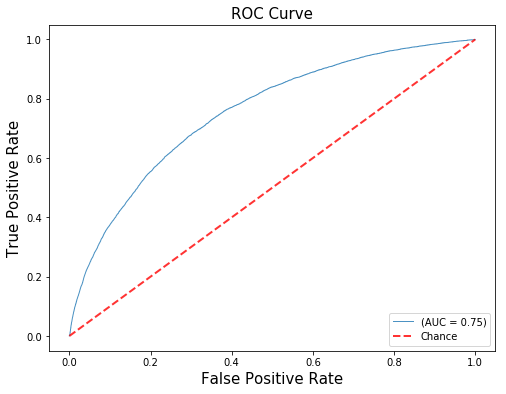

In [4]:
# Testing AdaBoost on the test set
clr = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate = 1, n_estimators=300, random_state=777)

metrics, chart, matrix = classify_test_set(clr, np.array(train_set), np.array(train_labels), np.array(test_set), np.array(test_labels), 'under')

# Saving results
#metrics.to_csv(path+'/results/ADA_on_Test.csv')

print('\nConfusion matrix:\n'); print(matrix)
print('\nResults\n'); print(metrics)

<a id='summary'></a>
# 4. Summary of Test Set Results

[Return](#toc)

In [7]:
# Creating a summary dataframe from saved test results
test_summary = pd.read_csv(path + '/results/ADA_on_Test.csv', index_col=0)
test_summary.index=['AdaBoost']
test_summary.insert(loc=0, column='Ratio_Attributes', value='Yes')
test_summary.insert(loc=0, column='Testing_Source', value='Test_Set')

s = pd.read_csv(path+'/results/ADA_extras.csv', index_col=0).loc[['Mean'],]
s.index=['AdaBoost']
s.insert(loc=0, column='Ratio_Attributes', value='Yes')
s.insert(loc=0, column='Testing_Source', value='Cross_Validation')
test_summary = test_summary.append(s)

# Saving test summary
#test_summary.to_csv(path+'/results/ADA_test_summary.csv')

print('Summary of AdaBoost Results from Test Set and Cross-Validation:')
test_summary

Summary of AdaBoost Results from Test Set and Cross-Validation:


,Testing_Source,Ratio_Attributes,ROC_AUC,Recall,Precision,F1-Score,Accuracy
AdaBoost,Test_Set,Yes,0.754154,0.681391,0.165353,0.266125,0.696599
AdaBoost,Cross_Validation,Yes,0.756327,0.683641,0.166426,0.267679,0.698035


The results from the test set are in line with the cross validation results. 